In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
economicTimesSampleLabel_pos = pd.read_excel(r'sample.xlsx')

In [3]:
economicTimesSampleLabel_neg = pd.read_excel(r'zeros.xlsx', sheet_name=1)

In [4]:
economicTimesSampleLabel_pos.head()

,Unnamed: 0,article_heading,article_text,Decision,Justification
0,24,Several wind energy projects in slow lane sinc...,BENGALURU: A large number of wind energy proje...,1,Tamil Nadu Generation and Distribution Company...
1,29,SECI’s 1200 MW wind auction gets tepid response,BENGALURU: Wind energy developers were surpris...,1,Some developers claimed that SECI’s continuing...
2,42,CERC approves higher tariff for Adani Power's ...,The Central Electricity Regulatory Commission ...,1,"In its plea to the CERC last year, GUVNL had p..."
3,113,MERC approves 700 MW PPA of Tata Power for fiv...,The Maharashtra Electricity Regulatory Commiss...,1,The Maharashtra Electricity Regulatory Commiss...
4,148,Green Companies continue to bid aggressively f...,BENGALURU: Renewable energy firms are continui...,1,the winners in the latest auction including Fi...


In [5]:
economicTimesSampleLabel_neg.head()

,Index original,article_heading,article_text,Decision,Justification
0,5,Enron-Dabhol power project: Supreme Court clos...,The Supreme Court on Thursday closed the case ...,0,proceedings before the Justice Kurdukar Commis...
1,14,'India to add 10k MW wind energy capacity in 2...,"BILBAO: Siemens Gamesa Renewable Energy, the s...",0,German conglomerate Siemens and Spanish wind p...
2,15,Government defers oil block bid deadline by a ...,NEW DELHI: The government has again deferred t...,0,government has again deferred the last date f...
3,20,"8 GW solar bids worth Rs 40,000 crore cancelle...","Auctions for around 8,000 MW solar capacities ...",0,"Auctions for around 8,000 MW solar capacities ..."
4,26,"Adani Group wins projects across coal, gas, hi...",NEW DELHI: Billionaire Gautam Adani-led Adani ...,0,", Adani Enterprises Ltd is the flagship listed..."


In [6]:
# combining frames ;
model_dataset_pos = economicTimesSampleLabel_pos.iloc[:, 3:5]
model_dataset_neg = economicTimesSampleLabel_neg.iloc[:, 3:5]

In [7]:
model_test_sample_set = model_dataset_pos.append(model_dataset_neg, ignore_index=True)

In [8]:
model_test_sample_set.head(2)

,Decision,Justification
0,1,Tamil Nadu Generation and Distribution Company...
1,1,Some developers claimed that SECI’s continuing...


In [9]:
model_test_sample_set.tail(3)

,Decision,Justification
93,0,"An investment of about Rs 50,000 crore is expe..."
94,0,Bangalore International Airport Limited (BIAL...
95,0,More than four lakh applications have come in ...


In [10]:
len(model_test_sample_set)

96

# Dummy Model designing

> <h2> Data Cleaning : </h2> 

In [11]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re

In [12]:
# Importing the dataset

# Cleaning the texts
corpus = []

for each_justification in model_test_sample_set['Justification'] :
    
    each_justification = re.sub('[^a-zA-Z]', ' ', str(each_justification))
    each_justification = each_justification.lower()
    each_justification = each_justification.split()
    ps = PorterStemmer()
    each_justification = [ps.stem(word) for word in each_justification if not word in set(stopwords.words('english'))]
    each_justification = ' '.join(each_justification)
    corpus.append(each_justification)

In [13]:
len(corpus)

96

In [14]:
model_test_sample_set.head(1)

,Decision,Justification
0,1,Tamil Nadu Generation and Distribution Company...


In [15]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 700)
X = cv.fit_transform(corpus).toarray()
y = model_test_sample_set.iloc[:, 0].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [39]:
# output the vectorizer
# save the model to disk
filename = 'finalized_cv.sav'
pickle.dump(cv, open(filename, 'wb'))

In [16]:
cm

array([[ 9,  1],
       [ 0, 10]])

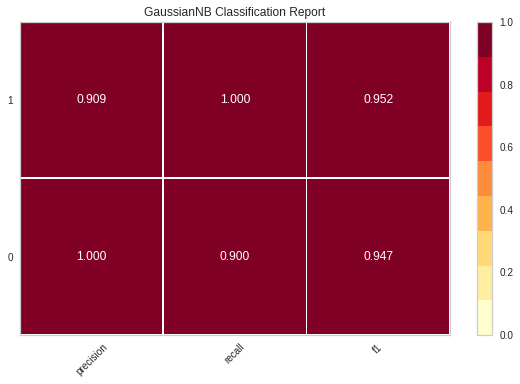

In [17]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(classifier, classes=[0,1])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer

visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

In [18]:
from sklearn.metrics import log_loss

In [19]:
log_loss(y_test, y_pred)

1.7269787996170447

In [20]:
classifier.predict_proba(X_test)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

AUC: 0.950


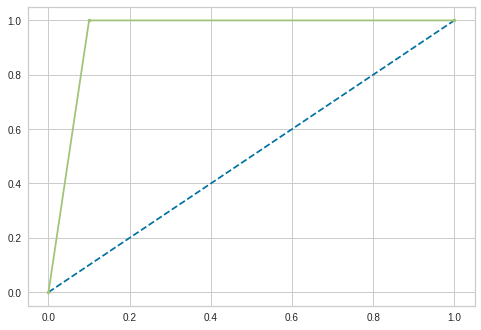

In [22]:
# predict probabilities
probs = classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [23]:
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.950


In [24]:
import pickle

In [25]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [26]:
X_train

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [29]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.95


# Random Forest model

In [30]:
from sklearn.ensemble import RandomForestClassifier
classifier_RM = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_RM.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# SVM

In [31]:
from sklearn.svm import SVC
SVCclassifier = SVC(kernel = 'linear', random_state = 0, probability=True)
SVCclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

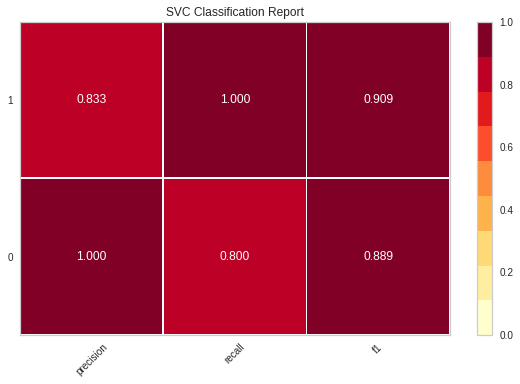

In [32]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(SVCclassifier, classes=[0,1])

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer

visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

In [33]:
SVCclassifier.predict_proba(X_test)

array([[0.00385592, 0.99614408],
       [0.94523468, 0.05476532],
       [0.18439449, 0.81560551],
       [0.90939233, 0.09060767],
       [0.7195288 , 0.2804712 ],
       [0.08205611, 0.91794389],
       [0.01930329, 0.98069671],
       [0.60311596, 0.39688404],
       [0.50828718, 0.49171282],
       [0.90735894, 0.09264106],
       [0.95730827, 0.04269173],
       [0.90524468, 0.09475532],
       [0.89938486, 0.10061514],
       [0.29786914, 0.70213086],
       [0.00715169, 0.99284831],
       [0.0036681 , 0.9963319 ],
       [0.01140774, 0.98859226],
       [0.31184933, 0.68815067],
       [0.39199881, 0.60800119],
       [0.01978665, 0.98021335]])

In [34]:
y_pred_svc = SVCclassifier.predict(X_test)

AUC: 0.960


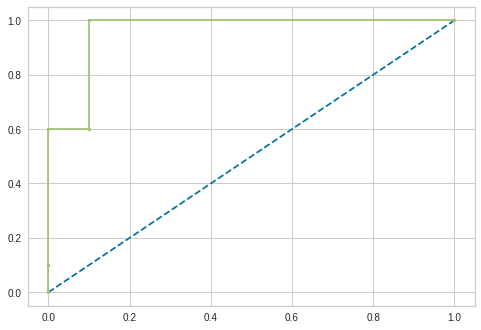

In [35]:
# predict probabilities
probs = SVCclassifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [36]:
cm = confusion_matrix(y_test, y_pred_svc)

In [37]:
cm

array([[ 8,  2],
       [ 0, 10]])

In [38]:
# save the model to disk
filename = 'finalized_SVM_linear.sav'
pickle.dump(SVCclassifier, open(filename, 'wb'))

# Arranging the articles according to the need

In [ ]:
data = pd.read_excel('df_useful_index_finance_all.xlsx')

In [ ]:
data.head()

In [ ]:
article = data.iloc[:,2]

In [ ]:
article[0]

In [ ]:
corpus = []
for i in range(0, 1000):
    sentence = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)


In [ ]:
t =  article[0]

In [ ]:
t

In [ ]:
t = re.sub(r"[.]\n\n", '   ', t)
t

In [ ]:
m  = []

for e in t.split('   '):
    m.append(e)

In [ ]:
len(m)

In [ ]:
for each in m:
    print(each, "\n\n\n")

In [ ]:
z